In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Import project configuration
import sys
sys.path.append('..')
import config

# Set random seed
np.random.seed(config.RANDOM_SEED)

print("Libraries imported successfully")

Configuration loaded successfully!
Project root: C:\Users\hp\Desktop\gaf\Ghana-Armed-Forces-Personnel-Deployment-and-Attrition-Risk-Modeling
Random seed: 42
Target sample size: 1000 personnel
Libraries imported successfully


# Load Data


In [4]:
#load raw dataset 
data_path = config.RAW_DATA_DIR/config.PERSONNEL_DATA_FILE
df = pd.read_csv(data_path)

#convert data column 
df['contract_end_date'] = pd.to_datetime(df['contract_end_date'])

print(f"Data shape: {df.shape}")
df.head(3)

Data shape: (1000, 51)


,personnel_id,name,age,gender,service_branch,rank,MOS,years_of_service,contract_end_date,marital_status,...,promotion_eligible,peer_rating_score,civilian_job_offers,financial_stress_indicator,family_support_score,relocation_willingness,attrition_risk_score,attrition_risk,readiness_score,readiness_category
0,MIL00001,Allison Hill,35,Male,Army,Officer,Military Police,18,2026-09-22,Single,...,True,81.3,0.0,Low,95.6,Low,0.000000,NaN,62.0,Not Ready
1,MIL00002,Noah Rhodes,23,Female,Army,Junior,Cyber Operations,2,2025-03-01,Divorced,...,False,NaN,0.0,Low,24.6,High,34.614493,LOW_RISK,70.9,Limited
2,MIL00003,Angie Henderson,29,Male,Army,Junior,Special Forces,5,2027-01-20,Married,...,True,73.8,0.0,Low,61.7,Medium,0.000000,NaN,67.3,Not Ready


# Temporal Features 

In [7]:
def create_temporal_features(df):
    """
    create time-based features with decay function
    """
    
    
    # Training recency score (exponential decay)
    # Score decreases as training becomes stale
    df['training_recency_score'] = np.exp(-df['days_since_last_training'] / config.TRAINING_RECENCY_DECAY)
    
    # Deployment recency score 
    # Maxed at 999 for never-deployed 
    df['deployment_recency_score'] = np.where(
        df['months_since_last_deployment'] < 999,
        np.exp(-df['months_since_last_deployment'] / config.DEPLOYMENT_RECENCY_DECAY),
        0  # Never deployed = 0 recency
    
    )
    
    # Contract pressure 
    df['contract_pressure'] = (df['months_until_contract_end'] < config.CONTRACT_PRESSURE_THRESHOLD).astype(int)
    
    # Contract urgency 
    # Higher values = more urgent 
    df['contract_urgency_score'] = (48 - df['months_until_contract_end'].clip(0, 48)) / 48
    
    # Time in current rank (estimated based on years of service)
    df['time_in_rank_estimate'] = np.where(
        df['rank'] == 'Junior',
        df['years_of_service'],
        np.where(
            df['rank'] == 'NCO',
            np.maximum(0, df['years_of_service'] - 5),
            np.maximum(0, df['years_of_service'] - 10)
        )
    )
    
    # Training gap indicator
    df['training_gap'] = (df['days_since_last_training'] > 365).astype(int)
    
    print(f"creating 6 temporal features")
    
    return df

df = create_temporal_features(df)

temporal_cols = ['training_recency_score', 'deployment_recency_score', 'contract_pressure', 
                 'contract_urgency_score', 'time_in_rank_estimate', 'training_gap']
df[['personnel_id'] + temporal_cols].head() 

    

creating 6 temporal features


,personnel_id,training_recency_score,deployment_recency_score,contract_pressure,contract_urgency_score,time_in_rank_estimate,training_gap
0,MIL00001,0.033934,0.205290,0,0.562500,8,1
1,MIL00002,0.454349,0.000000,1,0.958333,2,0
2,MIL00003,0.088724,0.716531,0,0.479167,5,1
3,MIL00004,0.860708,0.311403,0,0.083333,5,0
4,MIL00005,0.787502,0.082085,0,0.479167,1,0


# Interaction Features 

In [9]:
def create_interaction_features(df):
    """
    Create interaction and ratio features.
    """
    
    # Training efficiency (hours per year of service)
    df['training_hours_per_year_service'] = df['total_training_hours'] / df['years_of_service'].replace(0, 1)
    
    # Health-Performance index (composite)
    df['health_performance_index'] = (df['health_index'] * df['performance_review_score']) / 100
    
    # Leave to deployment ratio
    df['leave_to_deployment_ratio'] = df['annual_leave_taken'] / df['months_deployed_last_3yrs'].replace(0, 1)
    
    # Skill decay factor (training recency × skills current)
    df['skill_decay_factor'] = df['training_recency_score'] * df['skills_current'].astype(int)
    
    # Fitness to age ratio (normalized)
    df['fitness_to_age_ratio'] = df['physical_fitness_score'] / df['age']
    
    # Deployments per year of service
    df['deployments_per_year'] = df['total_deployments'] / df['years_of_service'].replace(0, 1)
    
    # Commendations to discipline ratio
    df['commendations_to_discipline_ratio'] = df['commendations'] / df['disciplinary_actions'].replace(0, 1)
    
    # Training efficiency score
    df['training_efficiency'] = df['training_score_average'] * df['specialized_courses_completed']
    
    # Leave utilization rate
    df['leave_utilization_rate'] = df['annual_leave_taken'] / 30  # Max 30 days
    
    # Deployment load (months deployed / years of service)
    df['deployment_load'] = df['months_deployed_last_3yrs'] / (df['years_of_service'].replace(0, 1) * 12)
    
    print(f" Created 10 interaction features")
    return df

df = create_interaction_features(df)

# Display sample
interaction_cols = ['training_hours_per_year_service', 'health_performance_index', 
                   'skill_decay_factor', 'deployments_per_year', 'training_efficiency']
df[['personnel_id'] + interaction_cols].head()

 Created 10 interaction features


,personnel_id,training_hours_per_year_service,health_performance_index,skill_decay_factor,deployments_per_year,training_efficiency
0,MIL00001,68.111111,67.0878,0.000000,0.333333,732.8
1,MIL00002,210.000000,75.4110,0.454349,0.000000,239.4
2,MIL00003,109.600000,67.6500,0.000000,0.200000,0.0
3,MIL00004,131.200000,75.1689,0.860708,0.400000,0.0
4,MIL00005,0.000000,64.2130,0.787502,2.000000,296.8


# Aggregated Features 

In [10]:
def create_aggregated_features(df):
    """
    Create aggregated features based on peer groups.
    """
    
    # Unit average readiness (by rank + MOS)
    unit_readiness = df.groupby(['rank', 'MOS'])['readiness_score'].transform('mean')
    df['unit_avg_readiness'] = unit_readiness
    
    # Relative readiness (vs unit average)
    df['relative_readiness'] = df['readiness_score'] - df['unit_avg_readiness']
    
    # Branch attrition rate (historical, based on current data)
    branch_attrition = df.groupby('service_branch')['attrition_risk'].apply(
        lambda x: (x == 'HIGH_RISK').sum() / len(x)
    )
    df['branch_attrition_rate'] = df['service_branch'].map(branch_attrition)
    
    # MOS retention rate (inverse of attrition)
    mos_attrition = df.groupby('MOS')['attrition_risk'].apply(
        lambda x: (x == 'HIGH_RISK').sum() / len(x)
    )
    df['mos_retention_rate'] = 1 - df['MOS'].map(mos_attrition)
    
    # Peer group performance (by rank + years of service bracket)
    df['service_bracket'] = pd.cut(df['years_of_service'], bins=[0, 5, 10, 15, 30], 
                                    labels=['0-5', '6-10', '11-15', '16+'])
    peer_performance = df.groupby(['rank', 'service_bracket'], observed=True)['performance_review_score'].transform('mean')
    df['peer_group_performance'] = peer_performance
    
    # Performance trajectory (relative to peer group)
    df['performance_trajectory'] = np.where(
        df['performance_review_score'] > df['peer_group_performance'],
        'Above Average',
        np.where(
            df['performance_review_score'] < df['peer_group_performance'] - 5,
            'Below Average',
            'Average'
        )
    )
    
    # Average health by rank
    rank_health = df.groupby('rank')['health_index'].transform('mean')
    df['rank_avg_health'] = rank_health
    
    print(f"Created 7 aggregated features")
    return df

df = create_aggregated_features(df)

# Display sample
agg_cols = ['unit_avg_readiness', 'relative_readiness', 'branch_attrition_rate', 
           'mos_retention_rate', 'peer_group_performance', 'performance_trajectory']
df[['personnel_id'] + agg_cols].head()

Created 7 aggregated features


,personnel_id,unit_avg_readiness,relative_readiness,branch_attrition_rate,mos_retention_rate,peer_group_performance,performance_trajectory
0,MIL00001,71.262500,-9.262500,0.063934,0.969697,81.711224,Average
1,MIL00002,70.295833,0.604167,0.063934,0.935065,82.145141,Average
2,MIL00003,70.162791,-2.862791,0.063934,0.962025,82.145141,Average
3,MIL00004,70.488235,2.911765,0.080214,0.966667,82.145141,Above Average
4,MIL00005,71.008000,4.992000,0.044335,0.916667,82.145141,Average


# Risk Indicator Features 

In [11]:
def create_risk_indicators(df):
    """
    Create composite risk indicator features.
    """    
    # Wellness red flags (health OR medical issues)
    df['wellness_red_flag'] = (
        (df['health_index'] < 70) | 
        (df['days_on_medical_leave'] > 30) | 
        (df['mental_health_status'] == 'Concern')
    ).astype(int)
    
    # High stress indicator (financial + family)
    df['high_stress_indicator'] = (
        (df['financial_stress_indicator'] == 'High') | 
        (df['family_support_score'] < 50)
    ).astype(int)
    
    # Deployment fatigue flag
    df['deployment_fatigue'] = (df['months_deployed_last_3yrs'] > 24).astype(int)
    
    # Low engagement indicator (poor performance + disciplinary issues)
    df['low_engagement'] = (
        (df['performance_review_score'] < 70) | 
        (df['disciplinary_actions'] > 1)
    ).astype(int)
    
    # Career stagnation (years in rank > threshold with no promotion eligibility)
    df['career_stagnation'] = (
        (df['time_in_rank_estimate'] > 5) & 
        (~df['promotion_eligible'])
    ).astype(int)
    
    # Retention risk composite score
    # Weighted sum of multiple risk factors
    df['retention_risk_composite'] = (
        df['contract_pressure'] * 3 +
        df['wellness_red_flag'] * 2 +
        df['high_stress_indicator'] * 2 +
        df['low_engagement'] * 1 +
        df['deployment_fatigue'] * 1 +
        (df['civilian_job_offers'] > 0).astype(int) * 2
    )
    
    print(f" Created 6 risk indicator features")
    return df

df = create_risk_indicators(df)

# Display sample
risk_cols = ['wellness_red_flag', 'high_stress_indicator', 'deployment_fatigue', 
            'low_engagement', 'career_stagnation', 'retention_risk_composite']
df[['personnel_id'] + risk_cols].head()

 Created 6 risk indicator features


,personnel_id,wellness_red_flag,high_stress_indicator,deployment_fatigue,low_engagement,career_stagnation,retention_risk_composite
0,MIL00001,0,0,0,0,0,0
1,MIL00002,0,1,0,0,0,5
2,MIL00003,0,0,1,0,0,1
3,MIL00004,0,0,1,0,0,3
4,MIL00005,0,1,1,0,0,3


# Feature Summary 

In [12]:
# Count engineered features
original_features = 54  # From data generation
current_features = len(df.columns)
engineered_features = current_features - original_features

print("\n" + "-" * 60)
print("FEATURE ENGINEERING SUMMARY")
print("-" * 60)
print(f"Original features: {original_features}")
print(f"Engineered features: {engineered_features}")
print(f"Total features: {current_features}")
print("\nEngineered Features by Category:")
print(f" Temporal: 6")
print(f" Interaction: 10")
print(f" Aggregated: 7")
print(f" Risk Indicators: 6")
print(f" Total Engineered: {6+10+7+6}")
print("-" * 60)

# List all engineered features
engineered_feature_list = [
    'training_recency_score', 'deployment_recency_score', 'contract_pressure',
    'contract_urgency_score', 'time_in_rank_estimate', 'training_gap',
    'training_hours_per_year_service', 'health_performance_index', 
    'leave_to_deployment_ratio', 'skill_decay_factor', 'fitness_to_age_ratio',
    'deployments_per_year', 'commendations_to_discipline_ratio', 
    'training_efficiency', 'leave_utilization_rate', 'deployment_load',
    'unit_avg_readiness', 'relative_readiness', 'branch_attrition_rate',
    'mos_retention_rate', 'peer_group_performance', 'performance_trajectory',
    'rank_avg_health',
    'wellness_red_flag', 'high_stress_indicator', 'deployment_fatigue',
    'low_engagement', 'career_stagnation', 'retention_risk_composite'
]

print("\nEngineered Features List:")
for i, feat in enumerate(engineered_feature_list, 1):
    print(f"  {i:2d}. {feat}")


------------------------------------------------------------
FEATURE ENGINEERING SUMMARY
------------------------------------------------------------
Original features: 54
Engineered features: 27
Total features: 81

Engineered Features by Category:
 Temporal: 6
 Interaction: 10
 Aggregated: 7
 Risk Indicators: 6
 Total Engineered: 29
------------------------------------------------------------

Engineered Features List:
   1. training_recency_score
   2. deployment_recency_score
   3. contract_pressure
   4. contract_urgency_score
   5. time_in_rank_estimate
   6. training_gap
   7. training_hours_per_year_service
   8. health_performance_index
   9. leave_to_deployment_ratio
  10. skill_decay_factor
  11. fitness_to_age_ratio
  12. deployments_per_year
  13. commendations_to_discipline_ratio
  14. training_efficiency
  15. leave_utilization_rate
  16. deployment_load
  17. unit_avg_readiness
  18. relative_readiness
  19. branch_attrition_rate
  20. mos_retention_rate
  21. peer_grou

# Handle Missing Data 

In [15]:
# check missing data before imputation
missing_before = df.isnull().sum()
missing_before = missing_before[missing_before > 0].sort_values(ascending=False)

print("Before Imputation")
print("-" * 60)

if len(missing_before) > 0:
    missing_pct = (missing_before / len(df)* 100).round(2)
    missing_df = pd.DataFrame({
        'Feature': missing_before.index,
        'Missing Count': missing_before.values,
        'Missing %': missing_pct.values
    })
    print(missing_df.to_string(index=False))
    
else:
    print("No missing data found")

Before Imputation
------------------------------------------------------------
                       Feature  Missing Count  Missing %
         combat_exposure_level            673       67.3
             peer_rating_score            140       14.0
          family_support_score            111       11.1
                attrition_risk             93        9.3
               deployment_type             86        8.6
         days_on_medical_leave             75        7.5
wellness_program_participation             70        7.0
     emergency_leave_incidents             70        7.0
               service_bracket             67        6.7
        peer_group_performance             67        6.7
           civilian_job_offers             47        4.7
          mental_health_status             35        3.5


In [19]:
def handle_missing_data(df):
    """
    Impute missing values based on feature type
    """
    print("\Handle missing data...")
    
    # Numeric features - impute with median 
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)
            print(f"Imputed {col} with median: {median_val:.2f}")
    # Categorical features: impute with mode
    cateforical_col = df.select_dtypes(include=['object', 'category']).columns
    for col in cateforical_col:
        if df[col].isnull().sum() > 0:
            mode_val = df[col].mode()[0]
            df[col].fillna(mode_val, inplace=True)
            print(f"Imputed {col} with mode: {mode_val}")
    # Boolean features: impute with false 
    bool_cols = df.select_dtypes(include=['bool']).columns
    for col in bool_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(False, inplace=True)
            print(f"Imputed {col} with False")
    
    return df


df = handle_missing_data(df)
                      
missing_after = df.isnull().sum()
print(f"\nMissing values after imputation: {missing_after}")
                  

\Handle missing data...
Imputed days_on_medical_leave with median: 8.00
Imputed emergency_leave_incidents with median: 0.00
Imputed peer_rating_score with median: 81.45
Imputed civilian_job_offers with median: 0.00
Imputed family_support_score with median: 70.40
Imputed peer_group_performance with median: 82.15
Imputed mental_health_status with mode: Good
Imputed wellness_program_participation with mode: False
Imputed deployment_type with mode: Domestic
Imputed combat_exposure_level with mode: Low
Imputed attrition_risk with mode: LOW_RISK
Imputed service_bracket with mode: 0-5

Missing values after imputation: personnel_id                0
name                        0
age                         0
gender                      0
service_branch              0
                           ..
high_stress_indicator       0
deployment_fatigue          0
low_engagement              0
career_stagnation           0
retention_risk_composite    0
Length: 81, dtype: int64


# Feature Selection & Final Dataset 

In [20]:
# Features to exclude from modeling (identifiers, intermediate variables, date)
exclude_features = [
    'personnel_id',
    'name',
    'contract_end_date',
    'service_bracket',  # Categorical helper, covered by years_of_service
    'rank_ordered',     # Helper variable from EDA
    'deployment_bin',   # Helper variable from EDA
    'attrition_risk_score',  # Continuous version of target
    'readiness_category'     # Categorical version of target
]

# Create final feature set
features_to_keep = [col for col in df.columns if col not in exclude_features]

print("\nFinal Feature Set:")
print("-" * 60)
print(f"Total features for modeling: {len(features_to_keep)}")
print(f"Target variables: attrition_risk, readiness_score")
print(f"\nExcluded features: {len(exclude_features)}")
print(exclude_features)


Final Feature Set:
------------------------------------------------------------
Total features for modeling: 75
Target variables: attrition_risk, readiness_score

Excluded features: 8
['personnel_id', 'name', 'contract_end_date', 'service_bracket', 'rank_ordered', 'deployment_bin', 'attrition_risk_score', 'readiness_category']


In [21]:
# Create final dataset
df_final = df[features_to_keep].copy()

print(f"\nFinal dataset shape: {df_final.shape}")
print(f"Features: {df_final.shape[1]}")
print(f"Samples: {df_final.shape[0]}")

# Display sample
df_final.head()


Final dataset shape: (1000, 75)
Features: 75
Samples: 1000


,age,gender,service_branch,rank,MOS,years_of_service,marital_status,dependents,education_level,months_until_contract_end,...,mos_retention_rate,peer_group_performance,performance_trajectory,rank_avg_health,wellness_red_flag,high_stress_indicator,deployment_fatigue,low_engagement,career_stagnation,retention_risk_composite
0,35,Male,Army,Officer,Military Police,18,Single,2,Associate,21,...,0.969697,81.711224,Average,82.613669,0,0,0,0,0,0
1,23,Female,Army,Junior,Cyber Operations,2,Divorced,1,High School,2,...,0.935065,82.145141,Average,87.233797,0,1,0,0,0,5
2,29,Male,Army,Junior,Special Forces,5,Married,1,High School,25,...,0.962025,82.145141,Average,87.233797,0,0,1,0,0,1
3,20,Male,Air Force,Junior,Aviation,5,Married,2,Master,44,...,0.966667,82.145141,Above Average,87.233797,0,0,1,0,0,3
4,21,Female,Navy,Junior,Administration,1,Married,0,High School,25,...,0.916667,82.145141,Average,87.233797,0,1,1,0,0,3


# Save Dataset

In [22]:
# Save to processed data directory
output_path = config.PROCESSED_DATA_DIR / config.FEATURES_ENGINEERED_FILE
df_final.to_csv(output_path, index=False)

print(f"\nEngineered dataset saved to: {output_path}")
print(f"   Shape: {df_final.shape}")
print(f"   Size: {output_path.stat().st_size / 1024 / 1024:.2f} MB")


Engineered dataset saved to: C:\Users\hp\Desktop\gaf\Ghana-Armed-Forces-Personnel-Deployment-and-Attrition-Risk-Modeling\data\processed\features_engineered.csv
   Shape: (1000, 75)
   Size: 0.50 MB


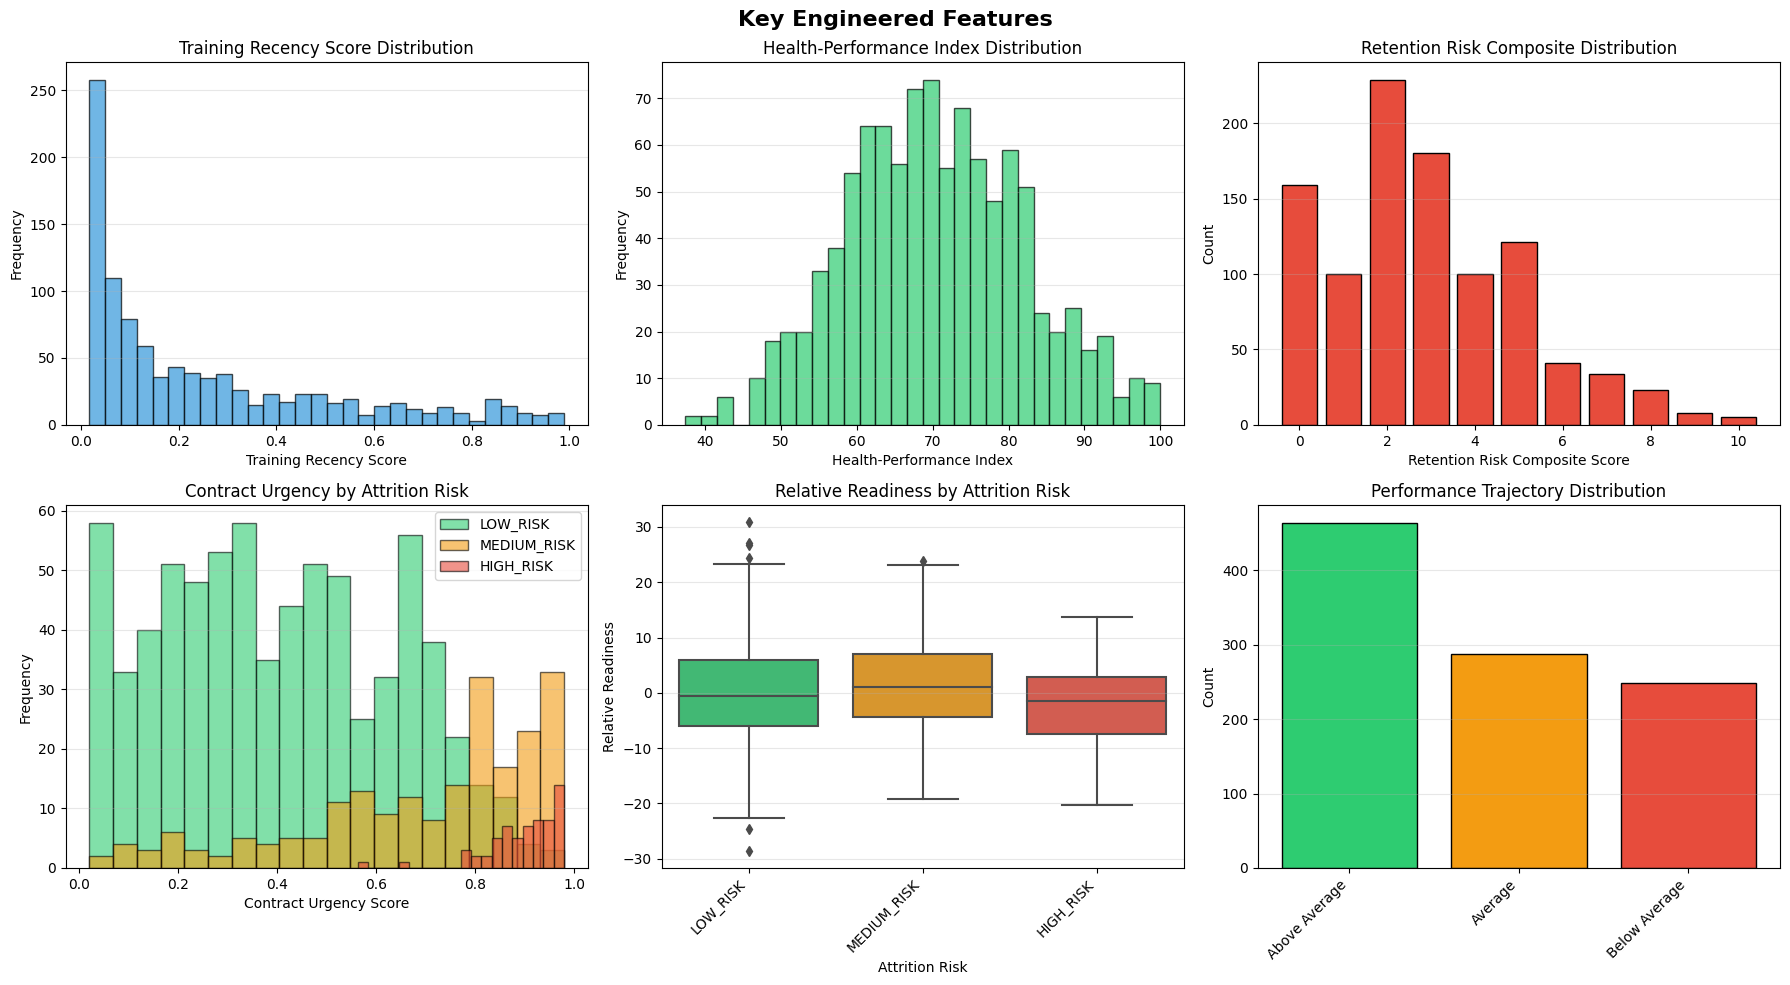

In [24]:
# Visualize some key engineered features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Key Engineered Features', fontsize=16, fontweight='bold')

# 1. Training recency score
axes[0, 0].hist(df_final['training_recency_score'], bins=30, color='#3498db', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Training Recency Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Training Recency Score Distribution')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Health-Performance index
axes[0, 1].hist(df_final['health_performance_index'], bins=30, color='#2ecc71', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Health-Performance Index')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Health-Performance Index Distribution')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Retention risk composite
risk_counts = df_final['retention_risk_composite'].value_counts().sort_index()
axes[0, 2].bar(risk_counts.index, risk_counts.values, color='#e74c3c', edgecolor='black')
axes[0, 2].set_xlabel('Retention Risk Composite Score')
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_title('Retention Risk Composite Distribution')
axes[0, 2].grid(axis='y', alpha=0.3)

# 4. Contract urgency by attrition risk
for risk in ['LOW_RISK', 'MEDIUM_RISK', 'HIGH_RISK']:
    subset = df_final[df_final['attrition_risk'] == risk]['contract_urgency_score']
    axes[1, 0].hist(subset, bins=20, alpha=0.6, label=risk, 
                    color=config.ATTRITION_COLORS[risk], edgecolor='black')
axes[1, 0].set_xlabel('Contract Urgency Score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Contract Urgency by Attrition Risk')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 5. Relative readiness vs attrition risk
sns.boxplot(data=df_final, x='attrition_risk', y='relative_readiness', ax=axes[1, 1],
            order=['LOW_RISK', 'MEDIUM_RISK', 'HIGH_RISK'],
            palette=[config.ATTRITION_COLORS['LOW_RISK'], 
                    config.ATTRITION_COLORS['MEDIUM_RISK'], 
                    config.ATTRITION_COLORS['HIGH_RISK']])
axes[1, 1].set_xlabel('Attrition Risk')
axes[1, 1].set_ylabel('Relative Readiness')
axes[1, 1].set_title('Relative Readiness by Attrition Risk')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right')
axes[1, 1].grid(axis='y', alpha=0.3)

# 6. Performance trajectory distribution
traj_counts = df_final['performance_trajectory'].value_counts()
colors_traj = ['#2ecc71', '#f39c12', '#e74c3c']
axes[1, 2].bar(range(len(traj_counts)), traj_counts.values, 
               color=colors_traj[:len(traj_counts)], edgecolor='black')
axes[1, 2].set_xticks(range(len(traj_counts)))
axes[1, 2].set_xticklabels(traj_counts.index, rotation=45, ha='right')
axes[1, 2].set_ylabel('Count')
axes[1, 2].set_title('Performance Trajectory Distribution')
axes[1, 2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(config.FIGURES_DIR / 'feature_engineering_overview.png', dpi=300, bbox_inches='tight')
plt.show()

